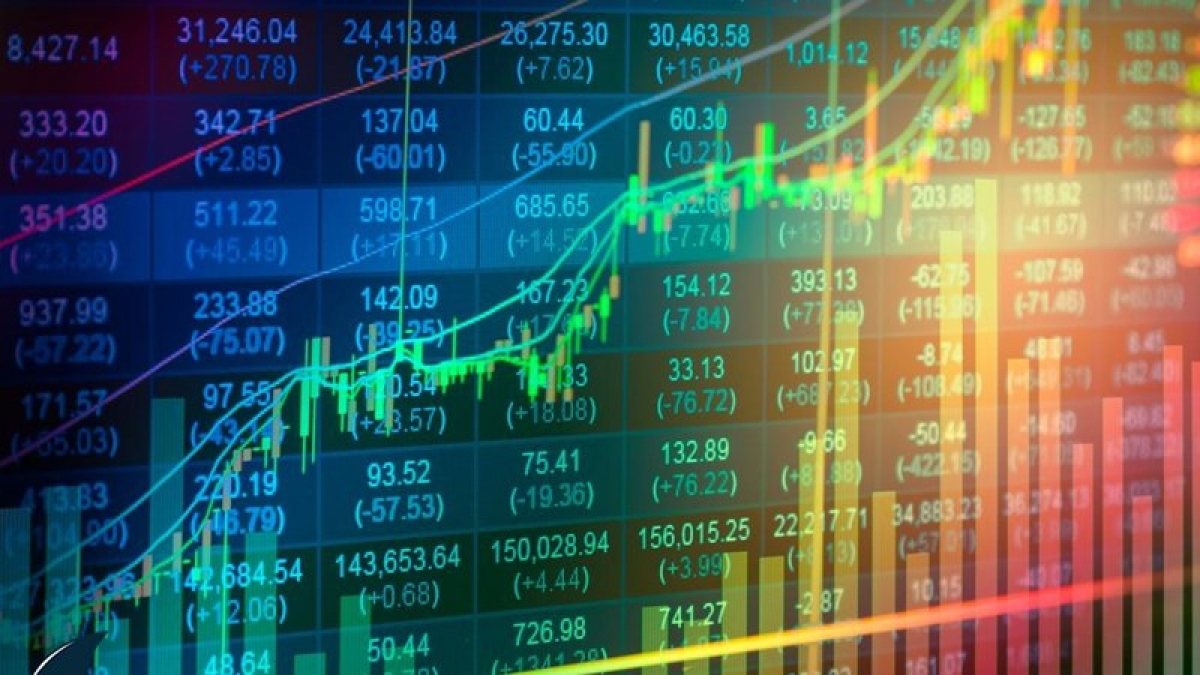

In [80]:
from PIL import Image 
from IPython.display import display
img = Image.open(r"C:\Users\DELL\Pictures\stock market.jpg")
display(img)

### Introduction

Recent advancements in computational techniques and data availability have significantly transformed financial analysis and stock market predictions. Among predictive models, Long Short-Term Memory (LSTM) networkand ARIMA model which s are particularly effective in capturing temporal dependencies in time series data. This study aims to develop a hybrid model that combines numerical analysis of historical stock prices of the S&P BSE Sensex with sentiment analysis of news headlines to improve stock price prediction accuracy.

The S&P BSE Sensex is a key indicator of India's economic health and investor sentiment. While traditional time series models excel in identifying price patterns, they often neglect the influence of external factors such as media sentiment, which can significantly affect market behavior. Research suggests that the sentiments expressed in financial news can influence investor decisions and lead to substantial price movements.

To address this gap, our hybrid model integrates LSTM networks with sentiment analysis from news headlines, leveraging the strengths of both numerical data and qualitative sentiment indicators. Historical price data reveals established trends, while sentiment analysis provides contextual insights into market reactions to current events.

This innovative approach aims to contribute to stock price prediction literature while offering practical tools for investors and analysts navigating the market's complexities. Ultimately, the research seeks to illuminate the intricate relationships between stock prices and public sentiment, promoting more informed investment decisions in a dynamic financial landscape.

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
# Download historical stock prices for the S&P BSE SENSEX
start = '2015-01-02'
end = datetime.now().strftime('%Y-%m-%d')

# The SENSEX index is represented by the ticker ^BSESN on Yahoo Finance
data = yf.download('^BSESN', start=start, end=end)

# Resetting index to make Date a column
data.reset_index(inplace=True)

print(data.head(-5))


[*********************100%%**********************]  1 of 1 completed

           Date          Open          High           Low         Close  \
0    2015-01-02  27521.279297  27937.470703  27519.259766  27887.900391   
1    2015-01-05  27978.429688  28064.490234  27786.849609  27842.320312   
2    2015-01-06  27694.230469  27698.929688  26937.060547  26987.460938   
3    2015-01-07  26983.429688  27051.599609  26776.119141  26908.820312   
4    2015-01-08  27178.769531  27316.410156  27101.939453  27274.710938   
...         ...           ...           ...           ...           ...   
2355 2024-08-01  81949.679688  82129.492188  81700.210938  81867.546875   
2356 2024-08-02  81158.992188  81345.601562  80868.906250  80981.953125   
2357 2024-08-05  78588.187500  79780.609375  78295.859375  78759.398438   
2358 2024-08-06  78981.968750  79852.078125  78496.570312  78593.070312   
2359 2024-08-07  79565.398438  79639.203125  79106.203125  79468.007812   

         Adj Close  Volume  
0     27887.900391    7400  
1     27842.320312    9200  
2     26987.

In [3]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,2365,2365.000000,2365.000000,2365.000000,2365.000000,2365.000000,2.365000e+03
mean,2019-10-24 06:46:43.890063104,43499.919709,43702.833506,43218.085562,43460.877691,43460.877691,1.479141e+05
min,2015-01-02 00:00:00,23060.390625,23142.960938,22494.609375,22951.830078,22951.830078,0.000000e+00
25%,2017-05-31 00:00:00,30285.609375,30534.150391,29987.439453,30188.150391,30188.150391,8.600000e+03
50%,2019-10-30 00:00:00,38137.871094,38297.699219,37828.109375,38050.781250,38050.781250,1.170000e+04
75%,2022-03-21 00:00:00,57817.511719,58141.960938,57494.910156,57858.148438,57858.148438,1.650000e+04
max,2024-08-14 00:00:00,81949.679688,82129.492188,81700.210938,81867.546875,81867.546875,3.181510e+07
std,NaN,15261.724051,15322.753925,15198.061688,15269.537792,15269.537792,1.536284e+06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2365 non-null   datetime64[ns]
 1   Open       2365 non-null   float64       
 2   High       2365 non-null   float64       
 3   Low        2365 non-null   float64       
 4   Close      2365 non-null   float64       
 5   Adj Close  2365 non-null   float64       
 6   Volume     2365 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 129.5 KB


In [6]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
len(data)

2365

# Visualize the Stock’s Daily Closing Price

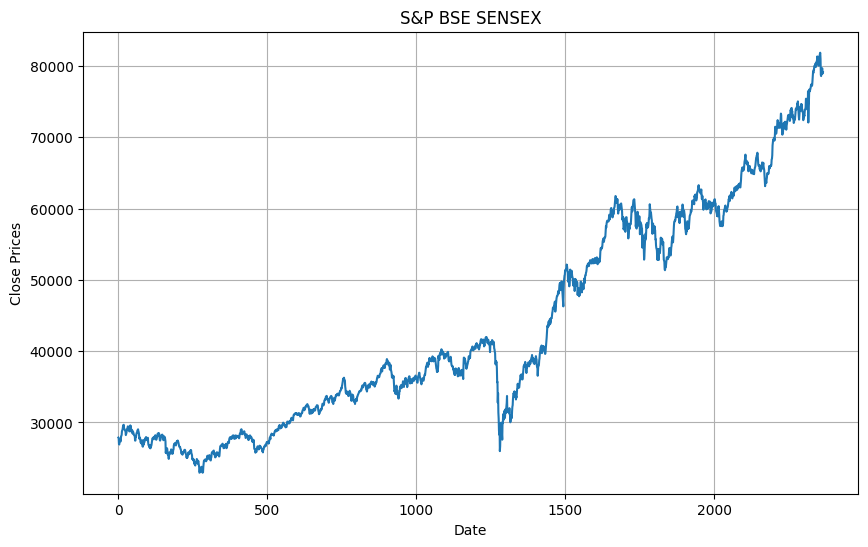

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('S&P BSE SENSEX')
plt.show()

This line extracts the closing prices of the stock and plots a Kernel Density Estimate (KDE) to visualize the probability distribution of closing prices.
It helps in understanding the distribution of the prices over the specified timeframe

<Axes: ylabel='Density'>

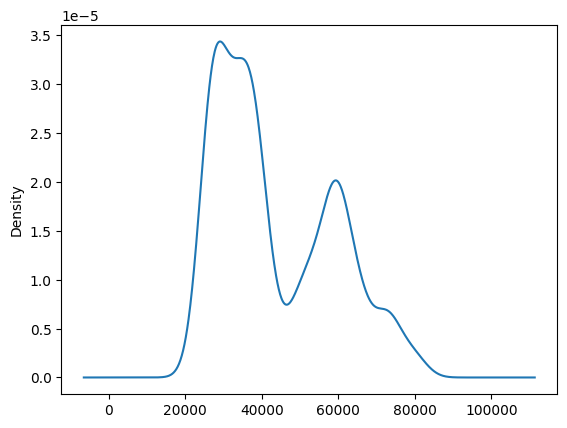

In [9]:
#We can also use a probability distribution to visualize the data in our series
data_close = data['Close']
data_close.plot(kind='kde')

# Test for Stationarity

The test_stationarity function calculates the rolling mean and standard deviation, then plots them to visualize trends over time.
It performs the Augmented Dickey-Fuller test to check for stationarity. Stationarity is an important property for time series forecasting, indicating that the statistical properties of a series remain constant over time.

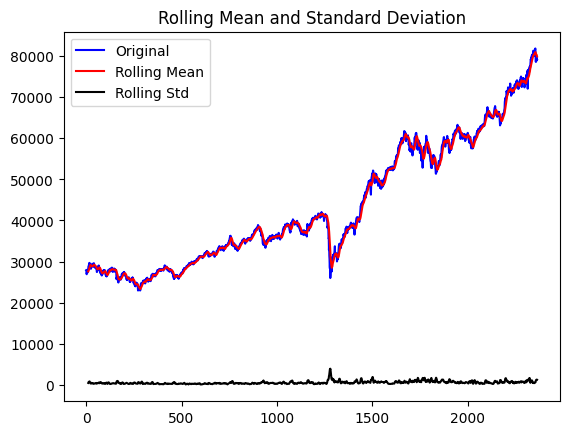

Results of dickey fuller test
Test Statistics                   0.870679
p-value                           0.992696
No. of lags used                  6.000000
Number of observations used    2358.000000
critical value (1%)              -3.433126
critical value (5%)              -2.862767
critical value (10%)             -2.567423
dtype: float64


In [10]:
#ADF (Augmented Dickey-Fuller) Test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(data_close)

Here’s a brief explanation of the results from the Augmented Dickey-Fuller (ADF) test:

1. **Test Statistic (0.870679)**: This value indicates the level of the test statistic derived from the ADF test. A more negative value generally suggests stronger evidence against the null hypothesis of non-stationarity.

2. **p-value (0.992696)**: This high p-value means that we fail to reject the null hypothesis of non-stationarity. In general, a p-value above 0.05 indicates that the time series is likely non-stationary.

3. **No. of lags used (6.000000)**: The number of lags included in the test, which can affect the ADF test's sensitivity. This number indicates that six lags were used in the regression.

4. **Number of observations used (2358.000000)**: The total number of observations (data points) included in the test. A larger sample size can lead to more reliable results.

5. **Critical values**: 
   - **Critical value (1%) = -3.433126**: If the test statistic is less than this value, we would reject the null hypothesis at the 1% significance level.
   - **Critical value (5%) = -2.862767**: If the test statistic is less than this value, we would reject the null hypothesis at the 5% significance level.
   - **Critical value (10%) = -2.567423**: If the test statistic is less than this value, we would reject the null hypothesis at the 10% significance level.

6. **Interpretation**: Since the test statistic (0.870679) is far greater than all critical values (i.e., -3.43, -2.86, and -2.57), and the p-value is very high (0.992696), we conclude that the time series is likely non-stationary. This suggests that the statistical properties of the series, like mean and variance, change over time, which can complicate forecasting efforts.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


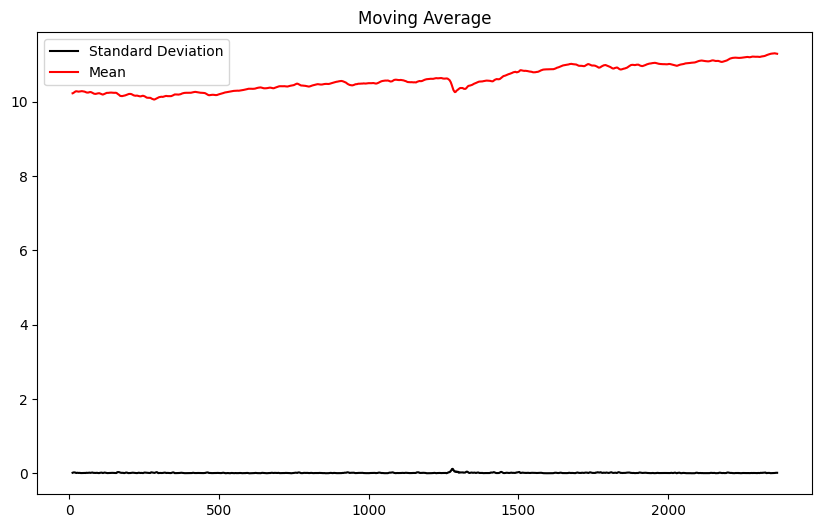

In [50]:
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Graph shows lower standard deviation which indicates stability as this line reflects variability or volatility in the log-transformed data within the window length of 12 

In [11]:
# Load news headlines
news_data = pd.read_csv('india-news-headlines.csv')

# Convert the publication date to datetime format
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], format='%Y%m%d')

# Check the data
print(news_data.head(-5))


        publish_date headline_category  \
0         2001-01-02           unknown   
1         2001-01-02           unknown   
2         2001-01-02           unknown   
3         2001-01-02           unknown   
4         2001-01-02           unknown   
...              ...               ...   
3650960   2022-03-31     city.ludhiana   
3650961   2022-03-31     city.ludhiana   
3650962   2022-03-31     city.ludhiana   
3650963   2022-03-31       city.indore   
3650964   2022-03-31       city.indore   

                                             headline_text  
0        Status quo will not be disturbed at Ayodhya; s...  
1                      Fissures in Hurriyat over Pak visit  
2                    America's unwanted heading for India?  
3                       For bigwigs; it is destination Goa  
4                     Extra buses to clear tourist traffic  
...                                                    ...  
3650960            Garment industry jittery over'GST hike'  
3650961

In [12]:
# Drop the 'headline_category' column
news_data = news_data.drop(columns=['headline_category'])

In [13]:
print(news_data.dtypes)


publish_date     datetime64[ns]
headline_text            object
dtype: object


In [14]:
news_data = news_data.groupby('publish_date', as_index=False)['headline_text'].agg(lambda x: ' '.join(x)).reset_index(drop=True)

In [15]:
news_data.isnull().sum()

publish_date     0
headline_text    0
dtype: int64

In [16]:
len(news_data)

7717

In [17]:
# Remove unwanted character from 'headline_text' column
news_data['headline_text'] = news_data['headline_text'].str.replace(r'[^\w\s]', '', regex=True)

In [18]:
print(news_data)

     publish_date                                      headline_text
0      2001-01-02  Status quo will not be disturbed at Ayodhya sa...
1      2001-01-03  Powerless north India gropes in the dark Think...
2      2001-01-04  The string that pulled Stephen Hawking to Indi...
3      2001-01-05  Light combat craft takes India into club class...
4      2001-01-06  Light combat craft takes India into club class...
...           ...                                                ...
7712   2022-03-27  Playing a dead man in Body God meant sitting i...
7713   2022-03-28  As fashion becomes democratic demand for styli...
7714   2022-03-29  Bobby Deol Like my dad I hope to be working wh...
7715   2022-03-30  I will not give in to trends Dossmode The time...
7716   2022-03-31  Shashank goes back to coastal Karnataka and Mo...

[7717 rows x 2 columns]


In [22]:
sia=SIA()
news_data['sentiment'] = news_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

Sentiment analysis is performed using VADER to create sentiment scores (ranging from -1 to 1) from the cleaned headline text.

In [139]:
# Aggregate sentiment by date
daily_sentiment = news_data.groupby('publish_date').agg({'sentiment': 'mean'}).reset_index()
#The sentiment scores are aggregated by publication date to create a daily average sentiment metric.

In [24]:
# Merge sentiment data with stock prices
merged_data = pd.merge(data, daily_sentiment, left_on='Date', right_on='publish_date', how='left')
merged_data.fillna(0, inplace=True)  # Fill missing sentiment values with 0

C:\Users\DELL\AppData\Local\Temp\ipykernel_5584\3277006668.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_data.fillna(0, inplace=True)  # Fill missing sentiment values with 0


In [85]:
# Prepare data for LSTM
data_close = merged_data['Close'].values
data_sentiment = merged_data['sentiment'].values

In [86]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.column_stack((data_close, data_sentiment)))


In [128]:
# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Include close price and sentiment
        y.append(data[i + time_step, 0])  # Predicting Close price
    return np.array(X), np.array(y)


In [129]:
time_step = 10  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, time_step)


In [130]:
# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [131]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)  # 2 features: Close and Sentiment
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

In [132]:
# Create LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:

# Early stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=1e-4, 
    mode='min', 
    restore_best_weights=True)

In [134]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping_monitor])


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0333 - val_loss: 0.0013
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 4.5456e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 3.2298e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5919e-04 - val_loss: 3.8837e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2055e-04 - val_loss: 0.0018
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7432e-04 - val_loss: 0.0013
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4582e-04 - val_loss: 5.2652e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8917e-04 - val_loss: 0.0015


In [135]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.column_stack((predictions, np.zeros_like(predictions))))[:, 0]  # Getting back the Close price


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


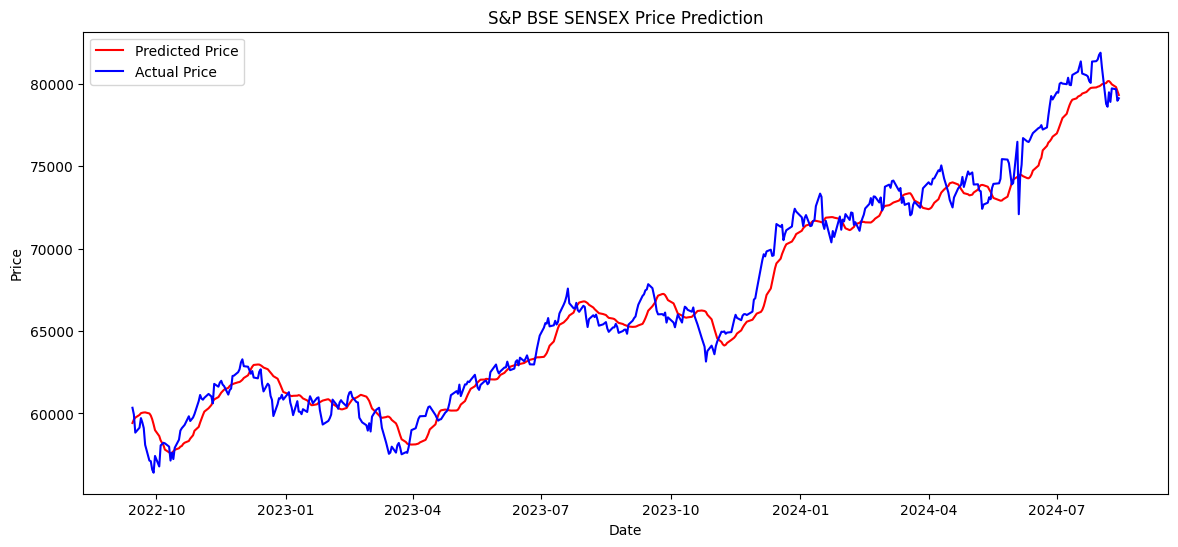

In [136]:
# Visualize the results
plt.figure(figsize=(14, 6))
plt.plot(data['Date'][train_size + time_step + 1:], predictions, color='red', label='Predicted Price')
plt.plot(data['Date'][train_size + time_step + 1:], data['Close'][train_size + time_step + 1:], color='blue', label='Actual Price')
plt.title('S&P BSE SENSEX Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Conclusion: Overall, this code provides a structured approach to perform stock price predictions using a combination of historical price data and news sentiment analysis. The use of deep learning techniques like LSTM allows for capturing complex patterns in time series data, which is enhanced further when combined with sentiment data, potentially leading to improved predictive performance. Analyzing and visualizing both the stock price and predictions helps in understanding the forecasting ability and evaluating the model effectively.